# COVID-19 Severity

Files needed:
- model
- External COVID-19 dataset with severity labels /braid/cellm/validation_data/combined_4dataset_processed_data.h5ad

In [13]:
import numpy as np
import scanpy as sc
from pascient.utils.reprod import load_binary_model, load_model
import torch
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import umap
from captum.attr import IntegratedGradients

In [15]:
# Loading pretrained model

run_name = "multilabel_model"
model_name = "modified" 
config_path = f"/homefs/home/debroue1/projects/pascient_github/resources/{run_name}/.hydra/"
checkpoint_path = f"/homefs/home/debroue1/projects/pascient_github/resources/{run_name}/checkpoints/{model_name}.ckpt"

model, dl = load_model(config_path = config_path, checkpoint_path = checkpoint_path)
model = model.eval()

y_index = 2 #in multilabel, 2 is the index of COVID-19 prediction

adata = sc.read_h5ad("/braid/cellm/validation_data/combined_4dataset_processed_data.h5ad")

hydra:
  run:
    dir: outputs/${now:%Y-%m-%d}/${now:%H-%M-%S}
  sweep:
    dir: multirun/${now:%Y-%m-%d}/${now:%H-%M-%S}
    subdir: ${hydra.job.num}
  launcher:
    _target_: hydra._internal.core_plugins.basic_launcher.BasicLauncher
  sweeper:
    _target_: hydra._internal.core_plugins.basic_sweeper.BasicSweeper
    max_batch_size: null
    params: null
  help:
    app_name: ${hydra.job.name}
    header: '${hydra.help.app_name} is powered by Hydra.

      '
    footer: 'Powered by Hydra (https://hydra.cc)

      Use --hydra-help to view Hydra specific help

      '
    template: '${hydra.help.header}

      == Configuration groups ==

      Compose your configuration from those groups (group=option)


      $APP_CONFIG_GROUPS


      == Config ==

      Override anything in the config (foo.bar=value)


      $CONFIG


      ${hydra.help.footer}

      '
  hydra_help:
    template: 'Hydra (${hydra.runtime.version})

      See https://hydra.cc for more info.


      == Flags ==

      

ModuleNotFoundError: No module named 'cellm'

In [3]:
# Aligning the data to the gene list used to train the models
gene_list = dl.gene_order

adata_new = sc.AnnData(np.zeros((1,len(gene_list))))
adata_new.var_names = gene_list
adata_c = sc.concat([adata_new, adata], join='outer', label='batch_new')

adata_c_f = adata_c[adata_c.obs['batch_new'] == '1']
adata_c_f = adata_c_f[:, gene_list]

## Computing embeddings and preditions

In [4]:
class ForwardModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    def forward(self, x, padding_mask):
        #assert x.shape[0] == 1
        cell_embds = self.base_model.gene2cell_encoder(x)
        cell_cross_embds = self.base_model.cell2cell_encoder(cell_embds, padding_mask = padding_mask)
        patient_embds = self.base_model.cell2patient_aggregation.aggregate(data = cell_cross_embds, mask = padding_mask)
        patient_embds = self.base_model.patient_encoder(patient_embds)
        patient_preds = self.base_model.patient_predictor(patient_embds)
        return patient_preds[:,0]

class ForwardDiffModel(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    def forward(self, x, padding_mask):
        #assert x.shape[0] == 1
        cell_embds = self.base_model.gene2cell_encoder(x)
        cell_cross_embds = self.base_model.cell2cell_encoder(cell_embds, padding_mask = padding_mask)
        patient_embds = self.base_model.cell2patient_aggregation.aggregate(data = cell_cross_embds, mask = padding_mask)
        patient_embds = self.base_model.patient_encoder(patient_embds)
        patient_preds = self.base_model.patient_predictor(patient_embds)
        #breakpoint()
        #healty 4, covid 2
        return (patient_preds[:,0,2] - patient_preds[:,0,4]).unsqueeze(-1)

def relu(x):
    return (x > 0).multiply(x)

In [ ]:
compute_IG= True # when True, computes IG attributions (takes more time)

sample_ids = []
embds = []
preds = []
pseudo_bulk = []
ig_dfs = []

model_fwd = ForwardModel(model)
#model_diff = ForwardDiffModel(model)
ig = IntegratedGradients(model_fwd)

for sample_id in tqdm.tqdm(adata_c_f.obs['sampleID'].unique()):

    sample_mask = adata_c_f.obs['sampleID'] == sample_id
    df_ = adata_c_f.obs.loc[sample_mask, :].copy()
    df_["sample_id_batch"] = 0
    df_["view_id"] = 0
    X_ = adata_c_f.X[sample_mask]

    X_ = X_.astype(np.float32)

    X_ = torch.Tensor(X_.toarray())

    dl.output_map.sample_labels = []
    dl.output_map.cell_labels = []
    dl.output_map.return_index = False
    dl.output_map.pad_size = X_.shape[0]
    dl.output_map.lognorm = False

    batch = dl.output_map((X_, df_))

    batch = model.masking_strategy(batch)
    x_full = batch.x
    padding_mask = batch.padded_mask

    cell_embds = model.gene2cell_encoder(x_full)

    cell_cross_embds = model.cell2cell_encoder(cell_embds, padding_mask = padding_mask)

    patient_embds = model.cell2patient_aggregation.aggregate(data = cell_cross_embds, mask = padding_mask)

    patient_embds = model.patient_encoder(patient_embds)

    patient_preds = model.patient_predictor(patient_embds)

    #Computing IG attributions (relu of attributions averaged by cell type)
    if compute_IG:
        random_mask = np.random.choice(batch.x.shape[2],1000)
        attr, delta  = ig.attribute(batch.x[:,:,random_mask], additional_forward_args=batch.padded_mask[:,:,random_mask], target = y_index, return_convergence_delta=True, baselines = torch.zeros_like(batch.x)[:,:,random_mask], internal_batch_size = 1)
        df_sub = df_.iloc[random_mask,:].copy()
        attr_relu = relu(attr).sum(-1)[0,0]
        df_sub["attr"] = attr_relu.detach().numpy()
        df_attr_cell_type = df_sub.groupby("celltype")["attr"].mean()
        ig_dfs.append(df_attr_cell_type)

    sample_ids.append(sample_id)
    embds.append(patient_embds.detach().numpy())
    preds.append(patient_preds.detach().numpy())
    pseudo_bulk.append(X_.mean(axis=0))

  0%|          | 0/116 [00:00<?, ?it/s]/tmp/ipykernel_391367/222595897.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_attr_cell_type = df_sub.groupby("celltype")["attr"].mean()
  1%|          | 1/116 [00:27<52:30, 27.39s/it]/tmp/ipykernel_391367/222595897.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_attr_cell_type = df_sub.groupby("celltype")["attr"].mean()
  2%|▏         | 2/116 [00:58<56:30, 29.74s/it]/tmp/ipykernel_391367/222595897.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

## Association between severity and predicted probability of COVID-19

In [124]:
disease_prob = torch.softmax(torch.Tensor(np.concatenate(preds)[:,0]),1).detach().numpy()[:,y_index] 
sample_2_severity = adata_c_f.obs.groupby("sampleID")["condition"].first().to_dict()
severity = [sample_2_severity[sample_id] for sample_id in sample_ids]
df_severity_prob = pd.DataFrame({"severity": severity, "disease_prob": disease_prob})

/tmp/ipykernel_2866220/968947470.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_2_severity = adata_c_f.obs.groupby("sampleID")["condition"].first().to_dict()


In [125]:
mild_probs = [prob for i, prob in enumerate(disease_prob) if sample_2_severity[sample_ids[i]] == "Mild"]
severe_probs = [prob for i, prob in enumerate(disease_prob) if sample_2_severity[sample_ids[i]] == "Severe"]
print("Wilcoxon rank sum test (Mild vs Severe):")
print(scipy.stats.ranksums(mild_probs, severe_probs, alternative='less'))

Wilcoxon rank sum test (Mild vs Severe):
RanksumsResult(statistic=-4.06730751994645, pvalue=2.3779731608810284e-05)


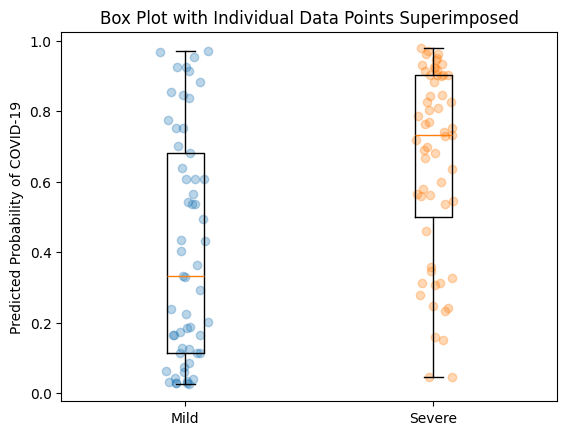

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
np.random.seed(0)
group_data = [
    df_severity_prob[df_severity_prob['severity'] == 'Mild']['disease_prob'].values,
    df_severity_prob[df_severity_prob['severity'] == 'Severe']['disease_prob'].values,
]

# Create box plot
fig, ax = plt.subplots()
ax.boxplot(group_data)

# Overlay individual data points, slightly jittered along x
for x_position, data in enumerate(group_data, start=1):
    # Jitter the x values around the center (x_position)
    x_jitter = np.random.normal(loc=x_position , scale=0.04, size=len(data))
    ax.scatter(x_jitter, data, marker='o', alpha = 0.3)

ax.set_xticks([1, 2])
ax.set_xticklabels(["Mild", "Severe"])
ax.set_ylabel("Predicted Probability of COVID-19")
ax.set_title("Box Plot with Individual Data Points Superimposed")
plt.savefig("./figures/severity_boxplot.pdf")

plt.show()


## UMAP colored by study and severity

In [127]:
studies = [sample_id.split("/")[1] for sample_id in sample_ids]

sample_embds = np.concatenate(embds)[:,0]

sample_embds -= sample_embds.mean(0)
sample_embds /= sample_embds.std(0)

# UMAP of sample embds
reducer = umap.UMAP(n_neighbors=35, min_dist = 1, random_state=42)
embedding = reducer.fit_transform(sample_embds)

/homefs/home/debroue1/miniforge3/envs/cellm/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


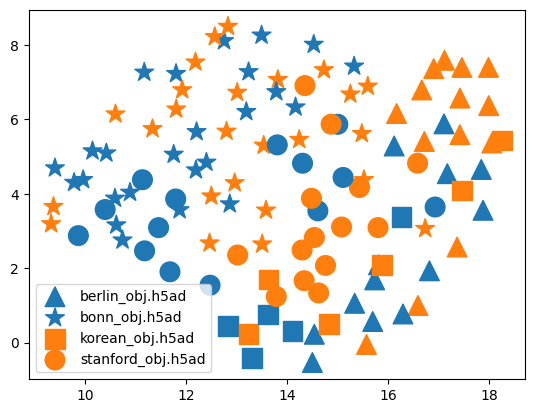

In [128]:
markers = ["o", "s", "*", "^"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"} #Mild is blue and Severe is Orange
plt.figure()
for study in np.unique(studies):
    mask = np.array(studies) == study
    plt.scatter(embedding[mask,0], embedding[mask,1], c = [col_dict[severity] for severity in np.array(severity)[mask]], s = 200, label = study, marker = markers.pop())
plt.legend()
plt.savefig("./figures/severity_embds_umap.pdf")
plt.show()

In [129]:
import sklearn.neighbors
from sklearn.metrics import davies_bouldin_score, adjusted_rand_score

severity_int = np.array(severity) == "Severe"
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(sample_embds, severity_int)
label_hat = knn.predict(sample_embds)
accuracy = (label_hat == severity_int).mean()
print(f" Accuracy of kNN for severity: {accuracy}")

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
study_int_dict = dict(zip(np.unique(studies), range(len(np.unique(studies)))))
study_int = np.array([study_int_dict[study] for study in studies])
knn.fit(sample_embds, study_int)
label_hat = knn.predict(sample_embds)
accuracy = (label_hat == study_int).mean()
print(f" Accuracy of kNN for study: {accuracy}")

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(sample_embds)
labels = kmeans.labels_

dbs_severity = davies_bouldin_score(sample_embds, severity_int)
print(f" DBS for severity: {dbs_severity}")
dbs_study = davies_bouldin_score(sample_embds, study_int)
print(f" DBS for study: {dbs_study}")


 Accuracy of kNN for severity: 0.7672413793103449
 Accuracy of kNN for study: 0.9396551724137931
 DBS for severity: 3.832234058305756
 DBS for study: 2.1880622173883117


## On pseudo-bulk

In [130]:
ps_bulk = torch.stack(pseudo_bulk)
ps_bulk -= ps_bulk.mean(0)
ps_bulk /= ps_bulk.std(0)
ps_bulk[ps_bulk.isnan()] = 0

# UMAP of sample embds
reducer = umap.UMAP(n_neighbors=35, min_dist = 1, random_state =42)
ps_bulk_reduced = reducer.fit_transform(ps_bulk)

/homefs/home/debroue1/miniforge3/envs/cellm/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


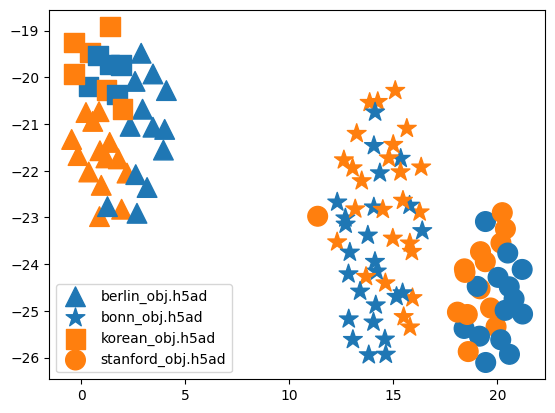

In [131]:
markers = ["o", "s", "*", "^"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"} #Mild is blue and Severe is Orange
plt.figure()
for study in np.unique(studies):
    mask = np.array(studies) == study
    plt.scatter(ps_bulk_reduced[mask,0], ps_bulk_reduced[mask,1], c = [col_dict[severity] for severity in np.array(severity)[mask]], s = 200, label = study, marker = markers.pop())
plt.legend()
plt.savefig("./figures/severity_pseudo_bulk_umap.pdf")
plt.show()

In [132]:
import sklearn.neighbors
from sklearn.metrics import davies_bouldin_score

severity_int = np.array(severity) == "Severe"
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(ps_bulk, severity_int)
label_hat = knn.predict(ps_bulk)
accuracy = (label_hat == severity_int).mean()
print(f" Accuracy of kNN for severity: {accuracy}")

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
study_int_dict = dict(zip(np.unique(studies), range(len(np.unique(studies)))))
study_int = np.array([study_int_dict[study] for study in studies])
knn.fit(ps_bulk, study_int)
label_hat = knn.predict(ps_bulk)
accuracy = (label_hat == study_int).mean()
print(f" Accuracy of kNN for study: {accuracy}")

dbs_severity = davies_bouldin_score(ps_bulk, severity_int)
dbs_study = davies_bouldin_score(ps_bulk, study_int)
print(f" DBS for severity: {dbs_severity}")
print(f" DBS for study: {dbs_study}")

 Accuracy of kNN for severity: 0.8017241379310345
 Accuracy of kNN for study: 0.9913793103448276
 DBS for severity: 6.0891219823627285
 DBS for study: 1.9684693658242594


## Association between attributions and severity

In [133]:
df_attrs = pd.concat([pd.DataFrame(ig_df).T for ig_df in ig_dfs])
df_attrs["severity"] = severity
df_attrs

celltype,B cells,CD4 T cells,CD8 T cells,Classical monocytes,Intermediate monocytes,Low-density neutrophils,MAIT cells,Myeloid dendritic cells,Natural killer cells,Non classical monocytes,Plasmablasts,Plasmacytoid dendritic cells,Platelet cells,T regulatory cells,gd T cells,mixed,severity
attr,0.009454,0.017500,0.009869,0.059017,0.020636,0.063627,0.024798,0.028471,0.018939,0.019492,0.091693,0.072178,0.854189,0.013926,0.011347,0.007969,Severe
attr,0.014943,0.013249,0.007061,0.101754,0.058341,0.071482,0.007282,0.038503,0.014124,0.126459,0.300694,NaN,0.065835,0.009775,0.020250,0.012271,Severe
attr,0.007305,0.004818,0.004863,0.049321,0.059390,0.046206,0.002485,0.006123,0.008725,NaN,0.142625,NaN,1.818587,0.003234,0.010575,0.003903,Mild
attr,0.005504,0.005947,0.005969,0.064664,0.046075,0.017093,0.004043,0.014062,0.015407,NaN,0.174673,0.040059,0.648675,0.004967,0.010814,0.002282,Severe
attr,0.008075,0.004208,0.006558,0.066567,0.030752,0.025544,0.002179,0.017511,0.010596,0.020084,0.042879,0.011832,0.256834,0.008550,0.008194,0.014477,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
attr,0.003789,0.002467,0.004001,0.002574,NaN,0.022257,0.000885,0.002139,0.005267,NaN,0.021248,NaN,0.076113,0.008525,0.001858,0.016404,Severe
attr,0.005427,0.003092,0.003254,0.004701,0.006329,0.025635,0.003802,0.007557,0.005588,NaN,0.013457,0.023659,0.068133,0.008273,0.000635,0.005994,Severe
attr,0.029144,0.033588,0.001511,0.009664,0.012958,0.006162,0.022783,0.005165,0.009190,NaN,0.063532,NaN,0.706540,0.373246,0.006513,NaN,Severe
attr,0.004865,0.036799,0.007422,0.004961,0.003380,0.028701,0.091991,0.007895,0.025598,0.002634,0.046921,NaN,0.507910,0.009381,0.008197,0.018987,Mild


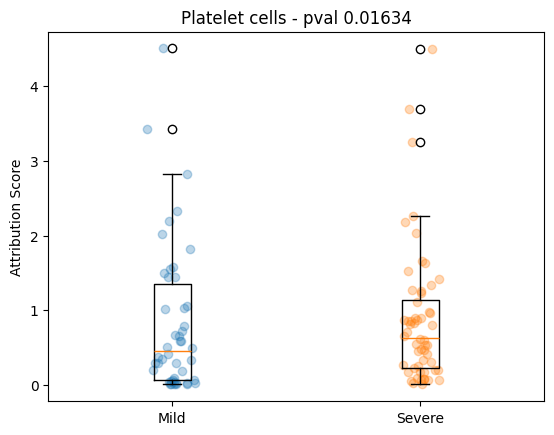

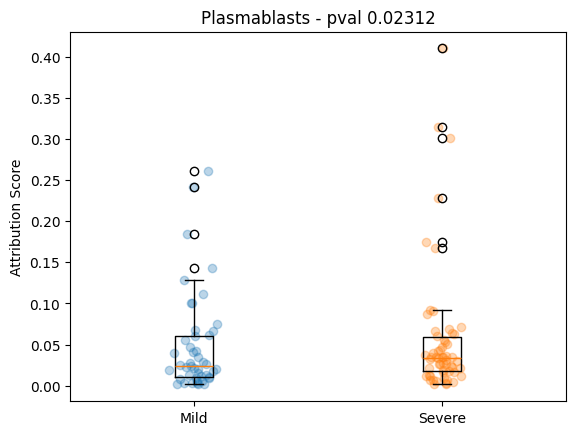

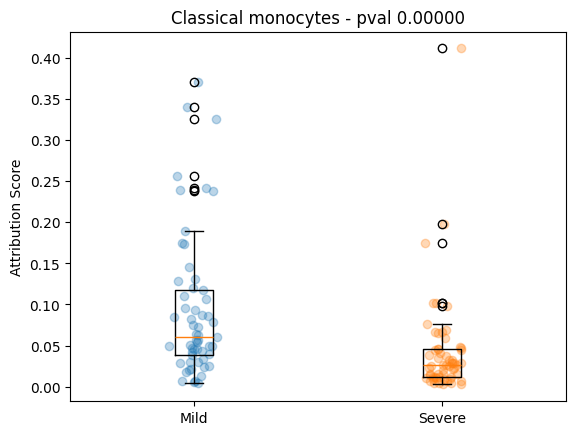

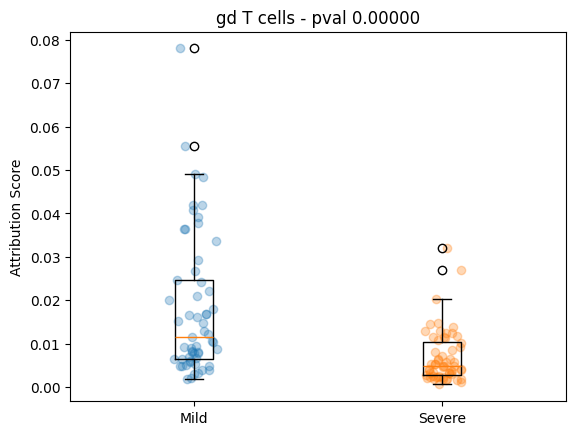

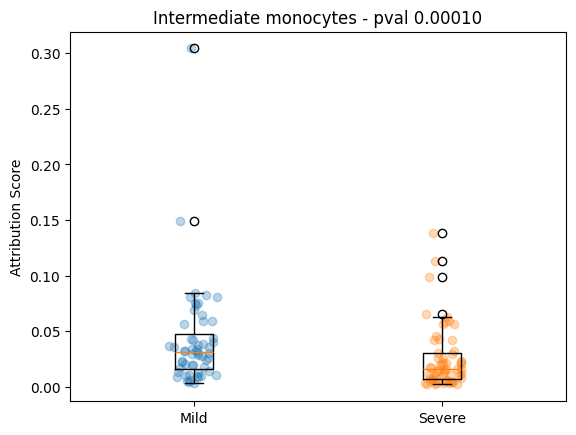

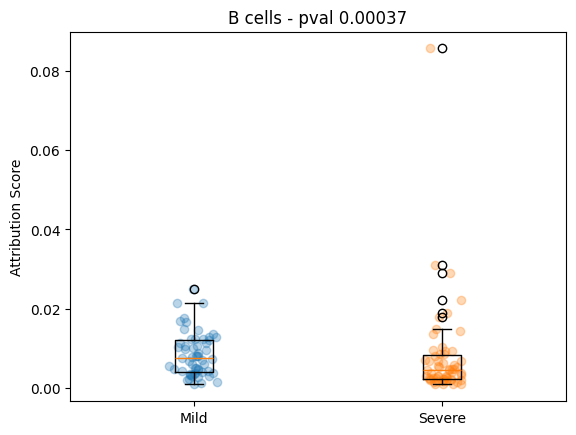

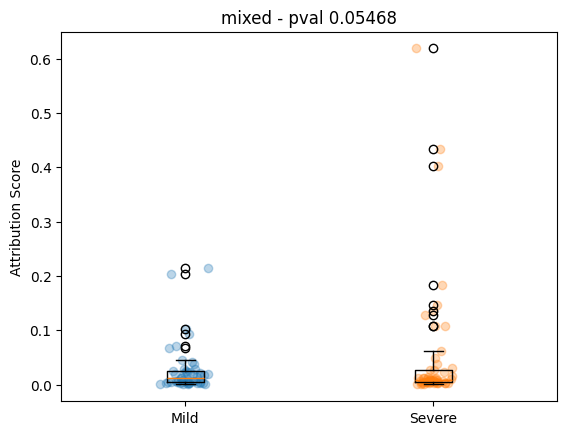

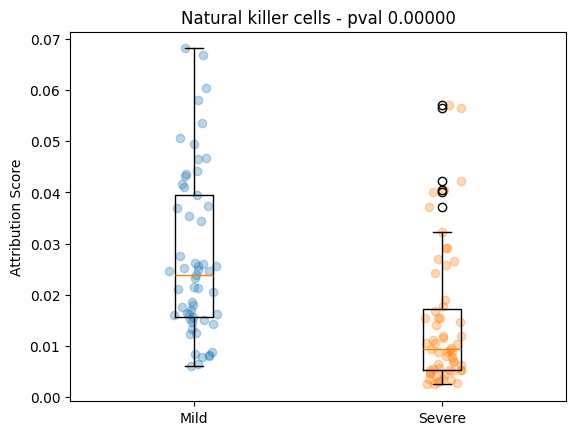

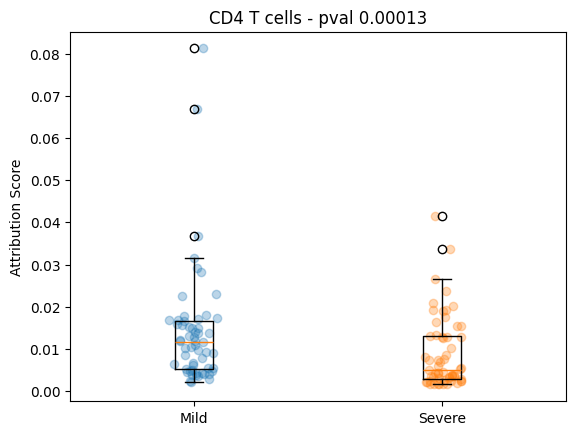

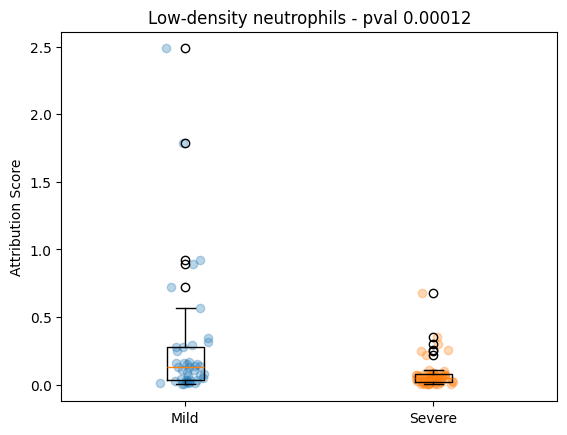

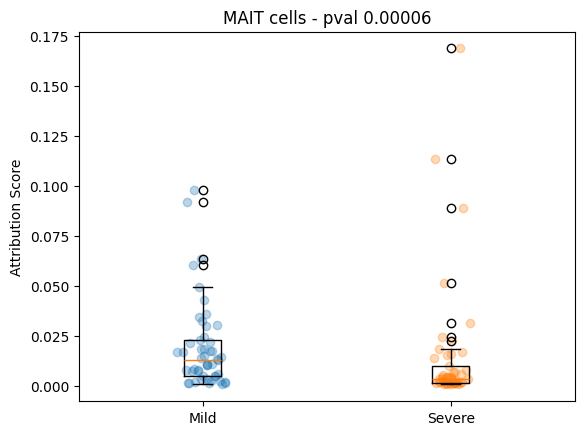

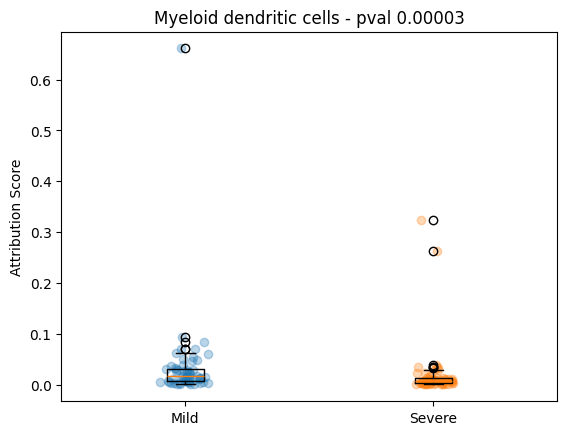

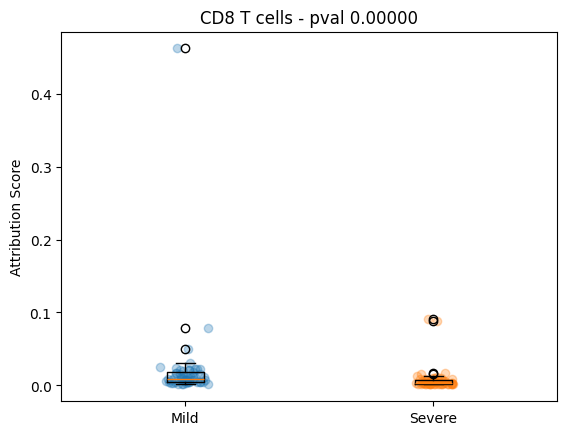

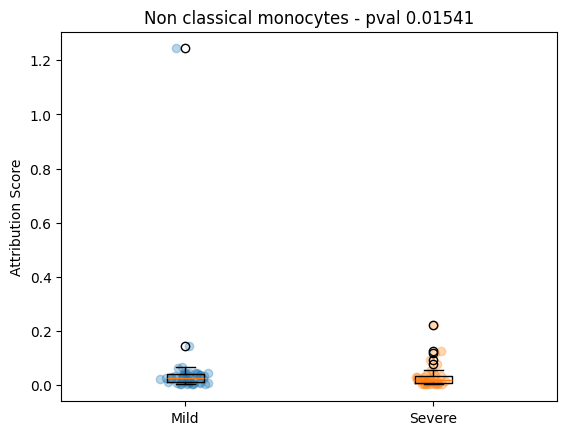

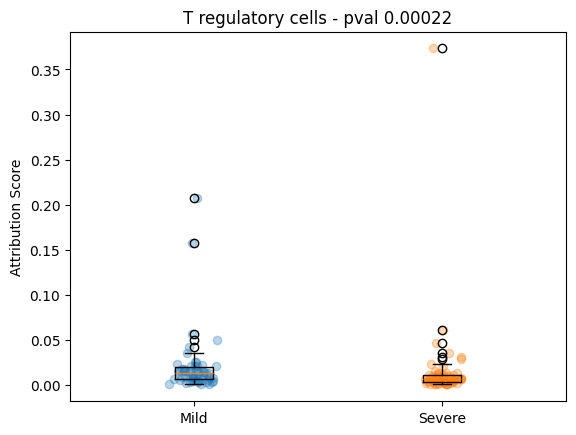

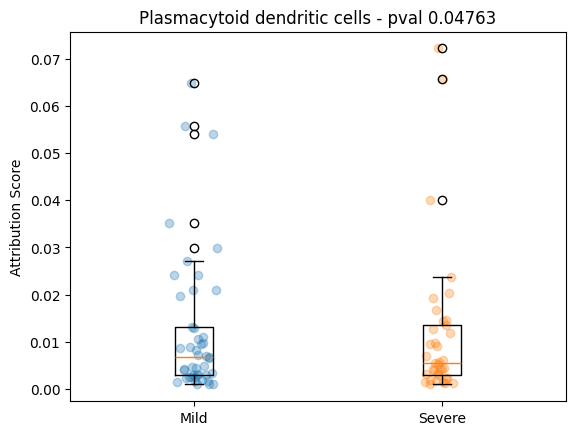

In [146]:
import numpy as np
import matplotlib.pyplot as plt

for cell_type in adata_c_f.obs["celltype"].unique():

    mild_probs = df_attrs.loc[df_attrs["severity"] == "Mild", cell_type].astype(float).values
    severe_probs = df_attrs.loc[df_attrs["severity"] == "Severe", cell_type].astype(float).values

    pval = scipy.stats.ranksums( severe_probs[~np.isnan(severe_probs)],mild_probs[~np.isnan(mild_probs)], alternative='two-sided')
    corr_pval = pval.pvalue/len(adata_c_f.obs["celltype"].unique())
    #print(f"Cell type: {cell_type} - corrected p_value - {corr_pval:.5f}")

    #df_attrs.boxplot(by = "severity", column =cell_type)

    # Example data
    np.random.seed(0)
    group_data = [
        mild_probs[~np.isnan(mild_probs)],
        severe_probs[~np.isnan(severe_probs)],
    ]

    # Create box plot
    fig, ax = plt.subplots()
    ax.boxplot(group_data)

    # Overlay individual data points, slightly jittered along x
    for x_position, data in enumerate(group_data, start=1):
        # Jitter the x values around the center (x_position)
        x_jitter = np.random.normal(loc=x_position , scale=0.04, size=len(data))
        ax.scatter(x_jitter, data, marker='o', alpha = 0.3)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["Mild", "Severe"])
    ax.set_ylabel("Attribution Score")
    ax.set_title(f"{cell_type} - pval {corr_pval:.5f}")
    plt.savefig(f"./figures/attribution_severity/{cell_type}.pdf")

    plt.show()